Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = r'D:\python\training\NLP\assignments_nlp\assignments_09\notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [32]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [33]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.894895
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.786222
Minibatch accuracy: 25.0%
Validation accuracy: 52.4%
Minibatch loss at step 100: 0.987062
Minibatch accuracy: 75.0%
Validation accuracy: 68.8%
Minibatch loss at step 150: 1.561156
Minibatch accuracy: 62.5%
Validation accuracy: 69.2%
Minibatch loss at step 200: 0.718967
Minibatch accuracy: 81.2%
Validation accuracy: 75.0%
Minibatch loss at step 250: 0.458269
Minibatch accuracy: 87.5%
Validation accuracy: 77.7%
Minibatch loss at step 300: 0.413178
Minibatch accuracy: 87.5%
Validation accuracy: 78.8%
Minibatch loss at step 350: 1.172178
Minibatch accuracy: 62.5%
Validation accuracy: 77.9%
Minibatch loss at step 400: 2.045689
Minibatch accuracy: 37.5%
Validation accuracy: 80.3%
Minibatch loss at step 450: 0.995349
Minibatch accuracy: 75.0%
Validation accuracy: 80.2%
Minibatch loss at step 500: 0.936498
Minibatch accuracy: 68.8%
Validation accuracy: 80.1%
M

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [39]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    
    hidden=tf.nn.max_pool(data,[1,2,2,1],[1,2,2,1],padding='SAME')# hidden 其实就是pooling

    hidden = tf.nn.conv2d(hidden, layer1_weights, [1, 2, 2, 1], padding='SAME')
    
    shape = hidden.get_shape().as_list()
    
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
 

    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))


num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.649940
Minibatch accuracy: 12.5%
Validation accuracy: 12.5%
Minibatch loss at step 50: 1.306250
Minibatch accuracy: 75.0%
Validation accuracy: 73.7%
Minibatch loss at step 100: 0.491931
Minibatch accuracy: 81.2%
Validation accuracy: 76.2%
Minibatch loss at step 150: 1.622724
Minibatch accuracy: 68.8%
Validation accuracy: 77.1%
Minibatch loss at step 200: 0.761970
Minibatch accuracy: 81.2%
Validation accuracy: 78.0%
Minibatch loss at step 250: 0.383405
Minibatch accuracy: 93.8%
Validation accuracy: 79.3%
Minibatch loss at step 300: 0.501774
Minibatch accuracy: 87.5%
Validation accuracy: 79.2%
Minibatch loss at step 350: 1.322002
Minibatch accuracy: 68.8%
Validation accuracy: 80.0%
Minibatch loss at step 400: 2.069441
Minibatch accuracy: 50.0%
Validation accuracy: 80.5%
Minibatch loss at step 450: 0.980753
Minibatch accuracy: 81.2%
Validation accuracy: 80.1%
Minibatch loss at step 500: 1.124326
Minibatch accuracy: 68.8%
Validation accuracy: 80.7%
M

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

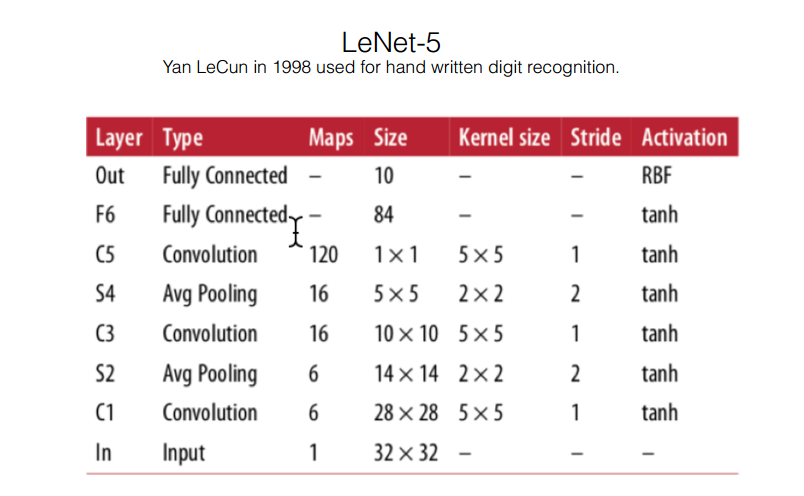

In [50]:
batch_size = 16
patch_size = 5
depth_1 = 6
depth_2 = 16
depth_3 = 120

num_hidden_1 = depth_3*1
num_hidden_2 = 84

learning_rating = 0.05
beta = 0.05

graph = tf.Graph()

with graph.as_default():

    '''Input data'''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    '''Variables'''
    # Convolution 1 Layer
    # Input channels: num_channels = 1
    # Output channels: depth = 6
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth_1], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth_1]))
    
    
    # Convolution 2 Layer
    # Input channels: depth = 6
    # Output channels: depth = 16
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]))
    
    
    # Convolution 3 Layer
    # Input channels: depth = 16
    # Output channels: depth = 120
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_3], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]))
    
    
     # first Fully Connected Layer
     # Input channels: 1*1*120 =120
    # Output channels: 84
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_2]))


    # Readout layer: second Fully Connected Layer
    # Output: 10
    layer5_weights = tf.Variable(tf.truncated_normal([num_hidden_2, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


    '''Model'''
    def model(data):
        # First Convolutional Layer with Pooling
        conv_1 = tf.nn.conv2d(data, layer1_weights, strides=[1, 1, 1, 1], padding='SAME')
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases)
#         print(hidden_1)
        pool_1 = tf.nn.avg_pool(hidden_1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
#         print(pool_1)
        # Second Convolutional Layer with Pooling
        conv_2 = tf.nn.conv2d(pool_1, layer2_weights, strides=[1, 1, 1, 1], padding='VALID')
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
#         print(hidden_2)
        pool_2 = tf.nn.avg_pool(hidden_2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
#         print(pool_2)

        # third Convolutional Layer
        conv_3 = tf.nn.conv2d(pool_2, layer3_weights, strides=[1, 1, 1, 1], padding='VALID')
        hidden_3 = tf.nn.relu(conv_3 + layer3_biases)
#         print(hidden_3)

        # First Fully Connected Layer
        shape = hidden_3.get_shape().as_list()
        reshape = tf.reshape(hidden_3, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
#         print(hidden)
        keep_prob = 0.4
        hidden_drop = tf.nn.dropout(hidden, keep_prob)

        # Second Fully Connected Layer
        hidden_3 = tf.matmul(hidden_drop, layer5_weights) + layer5_biases
#         print(hidden_3)
        return hidden_3

    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    # Loss function with L2 Regularization
    # regularizers = tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights)
    # loss = tf.reduce_mean(loss + beta * regularizers)

    '''Optimizer'''
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rating).minimize(loss)
    '''Predictions for the training, validation, and test data'''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
num_steps = 10001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 5.703708
Minibatch accuracy: 0.0%
Validation accuracy: 9.9%
Minibatch loss at step 500: 1.135809
Minibatch accuracy: 68.8%
Validation accuracy: 70.7%
Minibatch loss at step 1000: 1.445236
Minibatch accuracy: 62.5%
Validation accuracy: 77.0%
Minibatch loss at step 1500: 0.448541
Minibatch accuracy: 87.5%
Validation accuracy: 79.4%
Minibatch loss at step 2000: 0.787089
Minibatch accuracy: 87.5%
Validation accuracy: 80.9%
Minibatch loss at step 2500: 0.601818
Minibatch accuracy: 87.5%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.458771
Minibatch accuracy: 87.5%
Validation accuracy: 82.5%
Minibatch loss at step 3500: 0.349308
Minibatch accuracy: 87.5%
Validation accuracy: 82.4%
Minibatch loss at step 4000: 0.176035
Minibatch accuracy: 93.8%
Validation accuracy: 82.9%
Minibatch loss at step 4500: 0.310870
Minibatch accuracy: 87.5%
Validation accuracy: 84.2%
Minibatch loss at step 5000: 0.523612
Minibatch accuracy: 81.2%
Validation accuracy: